Inheriting VoxelMorph U-net architecture to use as our deep learning framework

In [ ]:
import torch
import voxelmorph as vxm
import glob
import os, sys
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
Dataset_path=Path("D:\\collegeCode\\sem4\\csd212_Project\\data\\synthetic_dataset\\train")
img_shape=(384, 512, 1)

print("Tensor flow version: ", tf.__version__)

Tensor flow version:  2.9.3


In [6]:
def load_pair(sample_path):
    moving=cv2.imread(str(sample_path/"snapshot.png"), cv2.IMREAD_GRAYSCALE)
    fixed=cv2.imread(str(sample_path/"he_target.png"), cv2.IMREAD_GRAYSCALE)

    moving=moving.astype(np.float32)/255.0
    fixed=fixed.astype(np.float32)/255.0

    moving=moving[...,np.newaxis]
    fixed=fixed[..., np.newaxis]

    return moving, fixed

def data_generator(sample_paths, batch_size=1):
    while True:
        idxs=np.random.choice(len(sample_paths), batch_size, replace=False)
        mov_batch=[]
        fix_batch=[]

        for i in idxs:
            m, f=load_pair(sample_paths[i])
            mov_batch.append(m)
            fix_batch.append(f)
        yield [np.array(mov_batch), np.array(fix_batch)], np.array(fix_batch)     

In [7]:
sample_dirs=sorted(list(Dataset_path.glob("sample_*")))
print(f"Found {len(sample_dirs)} relevant samples")

split=int(0.8*len(sample_dirs))
train_dirs=sample_dirs[:split]
test_dirs=sample_dirs[split:]

train_gen=data_generator(train_dirs, batch_size=1)

Found 1000 relevant samples


In [19]:
model=vxm.networks.VxmDense(
    inshape=img_shape[:2],
    nb_unet_features=[[32, 32, 32], [32, 32, 32]],
    bidir=False,
    int_steps=0,
    int_resolution=1,
    src_feats=1,
    trg_feats=1,
)

model.summary()

Model: "vxm_dense"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vxm_dense_source_input (InputL  [(None, 384, 512, 1  0          []                               
 ayer)                          )]                                                                
                                                                                                  
 vxm_dense_target_input (InputL  [(None, 384, 512, 1  0          []                               
 ayer)                          )]                                                                
                                                                                                  
 vxm_dense_unet_input_concat (C  (None, 384, 512, 2)  0          ['vxm_dense_source_input[0][0]', 
 oncatenate)                                                      'vxm_dense_target_input[

In [20]:
losses=[vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
loss_weights=[1.0, 2.0]

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights)

In [22]:
history=model.fit(train_gen, epochs=15, steps_per_epoch=len(train_dirs), verbose=1)

Epoch 1/15
800/800 [==============================] - 386s 482ms/step - loss: 0.0400 - vxm_dense_transformer_loss: 0.0381 - vxm_dense_flow_loss: 9.2955e-04
Epoch 2/15
800/800 [==============================] - 344s 430ms/step - loss: 0.0382 - vxm_dense_transformer_loss: 0.0360 - vxm_dense_flow_loss: 0.0011
Epoch 3/15
800/800 [==============================] - 315s 393ms/step - loss: 0.0383 - vxm_dense_transformer_loss: 0.0361 - vxm_dense_flow_loss: 0.0011
Epoch 4/15
800/800 [==============================] - 458s 573ms/step - loss: 0.0381 - vxm_dense_transformer_loss: 0.0358 - vxm_dense_flow_loss: 0.0011
Epoch 5/15
800/800 [==============================] - 311s 388ms/step - loss: 0.0382 - vxm_dense_transformer_loss: 0.0359 - vxm_dense_flow_loss: 0.0012
Epoch 6/15
800/800 [==============================] - 308s 385ms/step - loss: 0.0383 - vxm_dense_transformer_loss: 0.0359 - vxm_dense_flow_loss: 0.0012
Epoch 7/15
800/800 [==============================] - 310s 387ms/step - loss: 0.0381

1/1 [==============================] - 0s 285ms/step


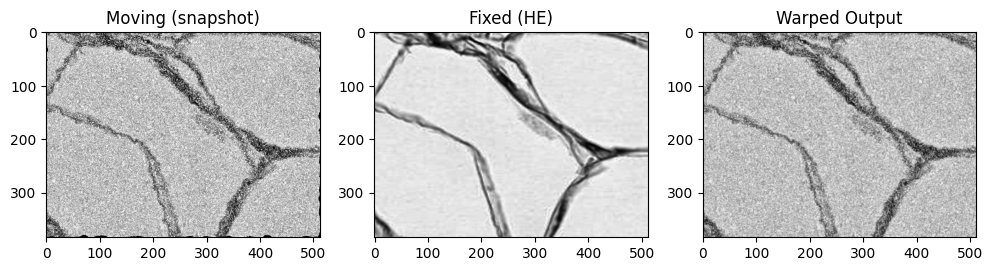

In [23]:
import matplotlib.pyplot as plt

(mov, fix), _=next(data_generator(test_dirs, batch_size=1))
pred=model.predict([mov, fix])

warped=pred[0][0, ..., 0]
moving=mov[0, ..., 0]
fixed=fix[0, ..., 0]

plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(moving, cmap='gray')
plt.title("Moving (snapshot)")
plt.subplot(1, 3, 2)
plt.imshow(fixed, cmap='gray')
plt.title("Fixed (HE)")
plt.subplot(1, 3, 3)
plt.imshow(warped, cmap='gray')
plt.title("Warped Output")
plt.show()

In [24]:
# Build your losses
losses = [
    vxm.losses.MSE().loss,                 # MSE
    vxm.losses.MutualInformation().loss,  # MI
    vxm.losses.Grad('l2').loss            # Smoothness
]

# Assign weights: [MSE, MI, Grad]
loss_weights = [1.0, 0.5, 2.0]  # You can tune 0.5 (γ) depending on results


tf.Tensor(449.99994, shape=(), dtype=float32)


In [25]:
from voxelmorph.tf.losses import MutualInformation

def compute_mi(img1, img2):
    '''compute mutual information between two grayscale images'''
    img1=tf.convert_to_tensor(img1[np.newaxis, ..., np.newaxis], dtype=tf.float32)
    img2=tf.convert_to_tensor(img2[np.newaxis, ..., np.newaxis], dtype=tf.float32)
    mi_fn=MutualInformation()
    return float(mi_fn.loss(img1, img2).numpy())

1/1 [==============================] - 0s 68ms/step
tf.Tensor(449.99994, shape=(), dtype=float32)
tf.Tensor(449.99994, shape=(), dtype=float32)
Sample 0: MI before=-0.0709, MI after=-0.1530


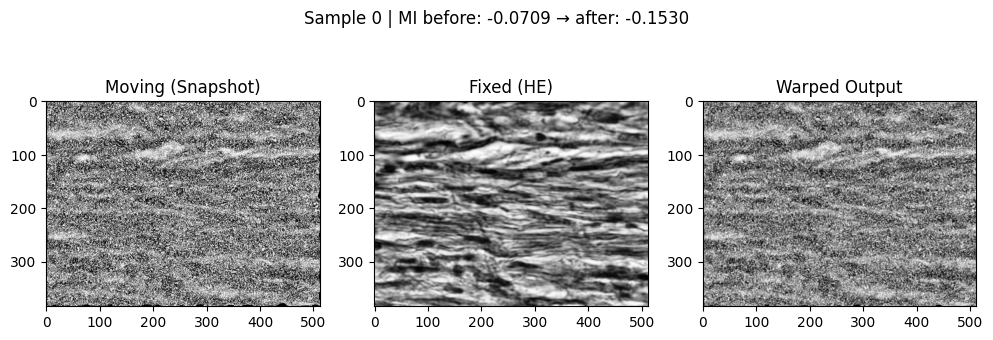

1/1 [==============================] - 0s 86ms/step
tf.Tensor(449.99994, shape=(), dtype=float32)
tf.Tensor(449.99994, shape=(), dtype=float32)
Sample 1: MI before=-0.2071, MI after=-0.3106


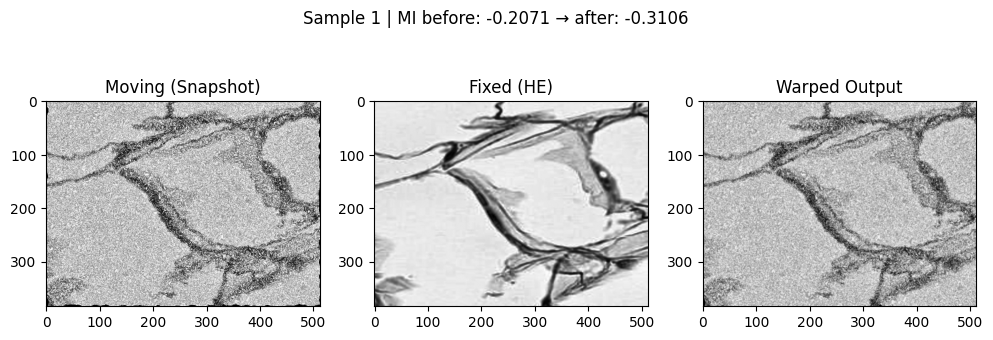

1/1 [==============================] - 0s 92ms/step
tf.Tensor(449.99994, shape=(), dtype=float32)
tf.Tensor(449.99994, shape=(), dtype=float32)
Sample 2: MI before=-0.1838, MI after=-0.2668


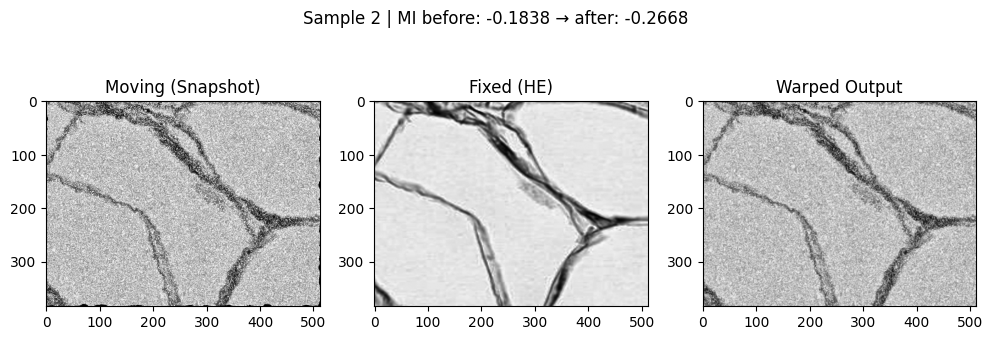

1/1 [==============================] - 0s 74ms/step
tf.Tensor(449.99994, shape=(), dtype=float32)
tf.Tensor(449.99994, shape=(), dtype=float32)
Sample 3: MI before=-0.0741, MI after=-0.1540


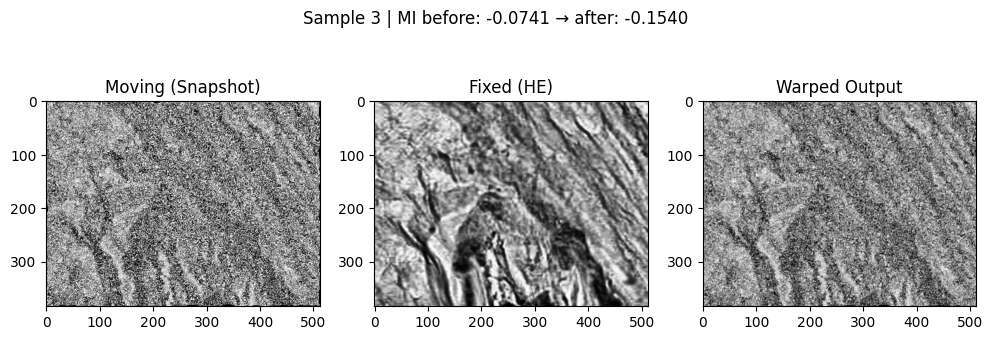

1/1 [==============================] - 0s 101ms/step
tf.Tensor(449.99994, shape=(), dtype=float32)
tf.Tensor(449.99994, shape=(), dtype=float32)
Sample 4: MI before=-0.0423, MI after=-0.0868


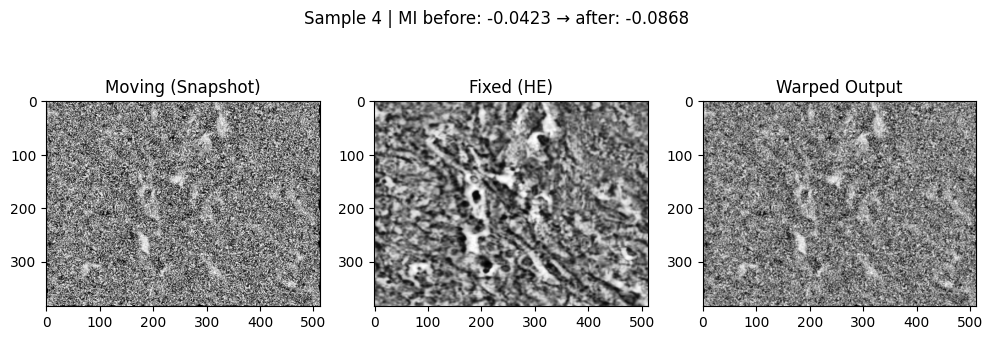

In [26]:
import matplotlib.pyplot as plt

N=5
for i in range(N):
    (mov, fix), _=next(data_generator(test_dirs, batch_size=1))
    pred=model.predict([mov, fix])
    warped=pred[0][0, ..., 0]

    moving=mov[0, ..., 0]
    fixed=fix[0, ..., 0]

    mi_before=compute_mi(moving, fixed)
    mi_after=compute_mi(warped, fixed)

    print(f"Sample {i}: MI before={mi_before:.4f}, MI after={mi_after:.4f}")

    plt.figure(figsize=(12,4))
    plt.suptitle(f"Sample {i} | MI before: {mi_before:.4f} → after: {mi_after:.4f}", fontsize=12)

    plt.subplot(1, 3, 1)
    plt.imshow(moving, cmap='gray')
    plt.title("Moving (Snapshot)")

    plt.subplot(1, 3, 2)
    plt.imshow(fixed, cmap='gray')
    plt.title("Fixed (HE)")

    plt.subplot(1, 3, 3)
    plt.imshow(warped, cmap='gray')
    plt.title("Warped Output")

    plt.show()

In [8]:
import voxelmorph as vxm


from tensorflow.keras.models import load_model
model = load_model(
    "vxm_model_final.h5", 
    compile=False,
    custom_objects={
        'VxmDense':vxm.networks.VxmDense,
        'SpatialTransformer': vxm.layers.SpatialTransformer
    }                   
)

model.save("vxm_model_final.h5")

In [9]:
def visualize_registration(moving, fixed, warped, title="Registration Overview"):
    # Normalize
    moving = np.clip(moving, 0, 1)
    fixed = np.clip(fixed, 0, 1)
    warped = np.clip(warped, 0, 1)

    # Red-Green overlay (warped = red, fixed = green)
    overlay = np.zeros((fixed.shape[0], fixed.shape[1], 3), dtype=np.float32)
    overlay[..., 0] = warped   # Red channel
    overlay[..., 1] = fixed    # Green channel

    # Plot all 3
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(moving, cmap='gray')
    plt.title("Moving (Snapshot)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(fixed, cmap='gray')
    plt.title("Fixed (HE)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay: Warped vs Fixed")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 73ms/step


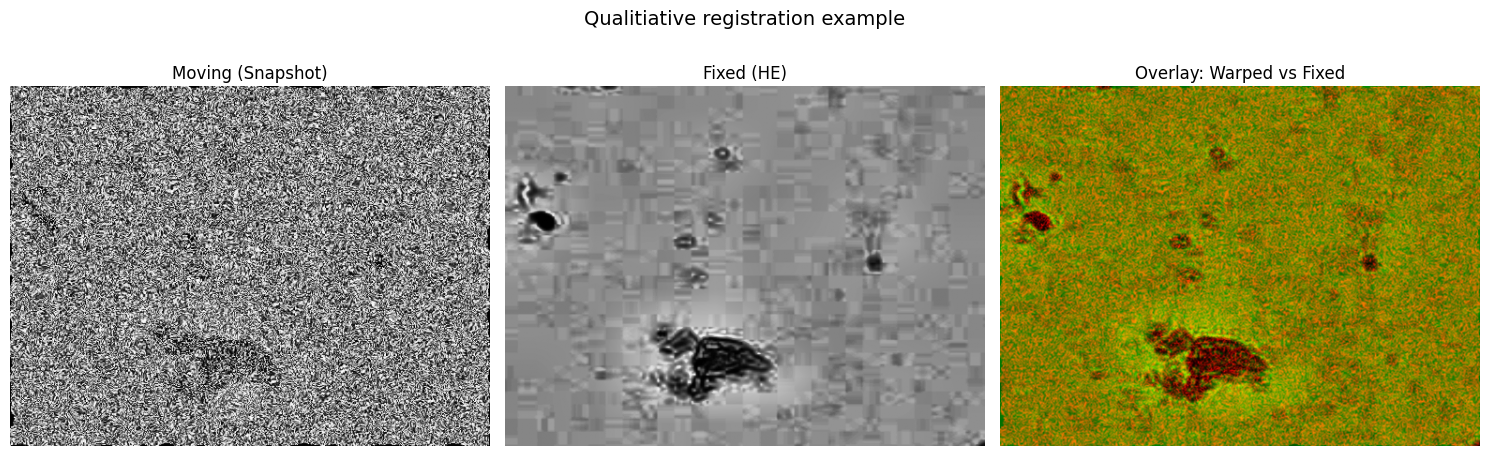

In [12]:
(mov, fix), _=next(data_generator(test_dirs, batch_size=1))
pred=model.predict([mov, fix])
warped=pred[0][0, ..., 0]
moving=mov[0, ..., 0]
fixed=fix[0, ..., 0]

visualize_registration(moving, fixed, warped, title="Qualitiative registration example")